In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import dask
import xarray as xr
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from models.autoencoder import Autoencoder
from losses import WeightedMSE,WeightedMSESignLoss, WeightedMSESignLossCorrLoss
from data_utils.datahandling import combine_observations
from preprocessing import align_data_and_targets, get_coordinate_indices, create_train_mask, reshape_obs_to_data
from preprocessing import AnomaliesScaler_v1, AnomaliesScaler_v2, Detrender, Standardizer, Normalizer, PreprocessingPipeline, Spatialnanremove
from torch_datasets import XArrayDataset
from subregions import subregions
from data_locations import LOC_FORECASTS_fgco2, LOC_OBSERVATIONS_fgco2

/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_name = 'results'
run_name = f'training_Autoencoder'
#out_dir = Path(dir_name, run_name)
#out_dir.mkdir(parents=True, exist_ok=True)

n_years =  25 # last n years to test consecutively
lead_years = 5
n_runs = 1  # number of training runs

params = {
    "model": Autoencoder,
    "arch" : 1, 
    "hidden_dims": [[3600, 1800, 900], [1800, 3600]],
    "time_features":  ['month_sin', 'month_cos','atm_co2'],
    "ensemble_features": False, ## PG
    'ensemble_list' : None, ## PG
    "epochs": 30,
    "batch_size": 1000,
    "batch_normalization": False,
    "dropout_rate": 0,
    "append_mode": 1,
    "hyperparam"  :1, 
    "reg_scale" : None,
    "optimizer": torch.optim.Adam,
    "lr": 100 ,
    "loss_region": None,
    "subset_dimensions": None
}


if params["model"] != Autoencoder:
    params["append_mode"] = None

params['forecast_preprocessing_steps'] = [
('anomalies', AnomaliesScaler_v1(axis=0)), 
('standardize', Standardizer(axis = (0,1))) ]

params['observations_preprocessing_steps'] = [
('anomalies', AnomaliesScaler_v2(axis=0))  ]
 

params['ensemble_list'] = None #[f'r{e}i1p2f1' for e in range(1,21,1)] ## PG
params['ensemble_mode'] = None
params['ensemble_features'] = False ## PG

params["arch"] = 2

params['reg_scale'] = 1
params['hyperparam'] = 1


In [3]:
data_dir_forecast = LOC_FORECASTS_fgco2
data_dir_obs = LOC_OBSERVATIONS_fgco2
unit_change = 60*60*24*365 * 1000 /12 * -1 ## Change units for ESM data to mol m-2 yr-1

print("Start training")
print("Load observations")
obs_in = combine_observations(data_dir_obs, two_dim=True) # 1961.01 - 2021.12

Start training
Load observations


In [4]:
ensemble_list = params['ensemble_list']
###### PG: Add ensemble features to training features
ensemble_mode = params['ensemble_mode'] ##
ensemble_features = params['ensemble_features']

In [5]:
print("Load forecasts") 
ds_in = xr.open_mfdataset(str(Path(data_dir_forecast, "*.nc")), combine='nested', concat_dim='year').mean('ensembles')['fgco2']


Load forecasts


In [6]:
obs_in = obs_in.expand_dims('channels', axis=2)

if 'ensembles' in ds_in.dims: ### PG: add channels dimention to the correct axis based on whether we have ensembles or not
    ds_in = ds_in.expand_dims('channels', axis=3).sortby('ensembles')
else:
    ds_in = ds_in.expand_dims('channels', axis=2) 

ds_raw, obs_raw = align_data_and_targets(ds_in, obs_in, 5)  # extract valid lead times and usable years



In [7]:
if 'ensembles' in ds_raw.dims: ## PG: reorder dimensions in you have ensembles
    ds_raw_ensemble_mean = ds_raw.transpose('year','lead_time','ensembles',...)* unit_change
else:
    ds_raw_ensemble_mean = ds_raw* unit_change

obs_raw = reshape_obs_to_data(obs_raw, ds_raw_ensemble_mean, return_xarray=True)

if not ds_raw_ensemble_mean.year.equals(obs_raw.year):
            
            ds_raw_ensemble_mean = ds_raw_ensemble_mean.sel(year = obs_raw.year)

In [30]:
# weights = np.cos(np.ones_like(ds_raw_ensemble_mean.lon) * (np.deg2rad(ds_raw_ensemble_mean.lat.to_numpy()))[..., None])  # Moved this up
# weights = xr.DataArray(weights, dims = ds_raw_ensemble_mean.dims[-2:], name = 'weights').assign_coords({'lat': ds_raw_ensemble_mean.lat, 'lon' : ds_raw_ensemble_mean.lon}) # Create an DataArray to pass to Spatialnanremove() 
# weights = weights - ds_raw_ensemble_mean[:,:12].mean(['year','lead_time']) + ds_raw_ensemble_mean[:,:12].mean(['year','lead_time']) + obs_raw[:,:12].mean(['year','month']) - obs_raw[:,:12].mean(['year','month'])
# weights = weights.squeeze()
# ds_raw_ensemble_mean_patterns = ds_raw_ensemble_mean - ((ds_raw_ensemble_mean * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
# obs_raw_patterns = obs_raw - ((obs_raw * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))

In [8]:
nanremover = Spatialnanremove()## PG: Get an instance of the class
nanremover.fit(ds_raw_ensemble_mean[:,:12,...], obs_raw[:,:12,...]) ## PG:extract the commong grid points between training and obs data
ds_raw_ensemble_mean = nanremover.to_map(nanremover.sample(ds_raw_ensemble_mean)) ## PG: flatten and sample training data at those locations
obs_raw = nanremover.to_map(nanremover.sample(obs_raw)) ## PG: flatten and sample obs data at those locations    

weights = np.cos(np.ones_like(ds_raw_ensemble_mean.lon) * (np.deg2rad(ds_raw_ensemble_mean.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = ds_raw_ensemble_mean.dims[-2:], name = 'weights').assign_coords({'lat': ds_raw_ensemble_mean.lat, 'lon' : ds_raw_ensemble_mean.lon}) # Create an DataArray to pass to Spatialnanremove() 
weights = nanremover.to_map(nanremover.sample(weights))

ds_raw_ensemble_mean_patterns = ds_raw_ensemble_mean - ((ds_raw_ensemble_mean * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
obs_raw_patterns = obs_raw - ((obs_raw * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
obs_raw = ((obs_raw * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).expand_dims('ref', axis=-1)

### check predictors and targets


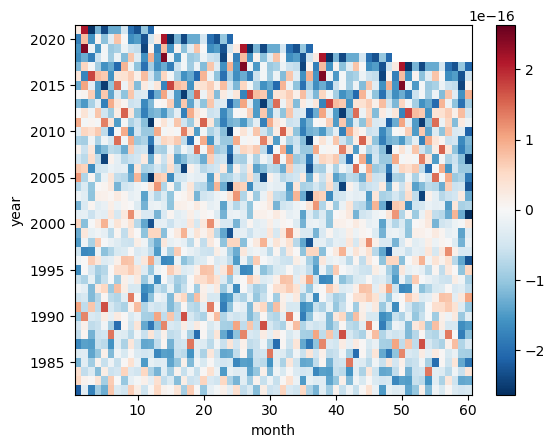

In [9]:
weights = np.cos(np.ones_like(ds_raw_ensemble_mean.lon) * (np.deg2rad(ds_raw_ensemble_mean.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = ds_raw_ensemble_mean.dims[-2:], name = 'weights').assign_coords({'lat': ds_raw_ensemble_mean.lat, 'lon' : ds_raw_ensemble_mean.lon})
weights = weights * xr.ones_like(obs_raw_patterns)
weights = weights - obs_raw_patterns + obs_raw_patterns

((obs_raw_patterns* weights).sum(['lat','lon'])/(weights).sum(['lat','lon'])).plot()

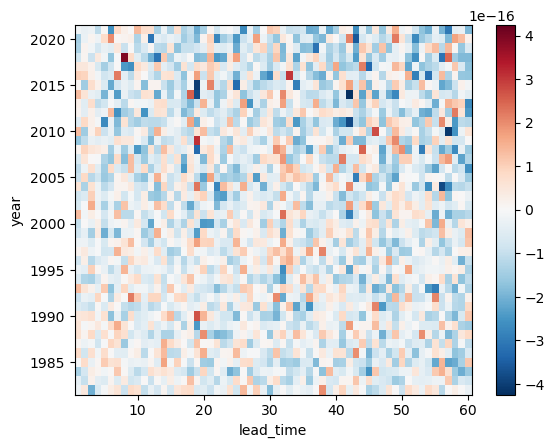

In [10]:
weights = np.cos(np.ones_like(ds_raw_ensemble_mean.lon) * (np.deg2rad(ds_raw_ensemble_mean.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = ds_raw_ensemble_mean.dims[-2:], name = 'weights').assign_coords({'lat': ds_raw_ensemble_mean.lat, 'lon' : ds_raw_ensemble_mean.lon})
weights = weights * xr.ones_like(ds_raw_ensemble_mean_patterns)
weights = weights - ds_raw_ensemble_mean_patterns + ds_raw_ensemble_mean_patterns

((ds_raw_ensemble_mean_patterns* weights).sum(['lat','lon'])/(weights).sum(['lat','lon'])).plot()

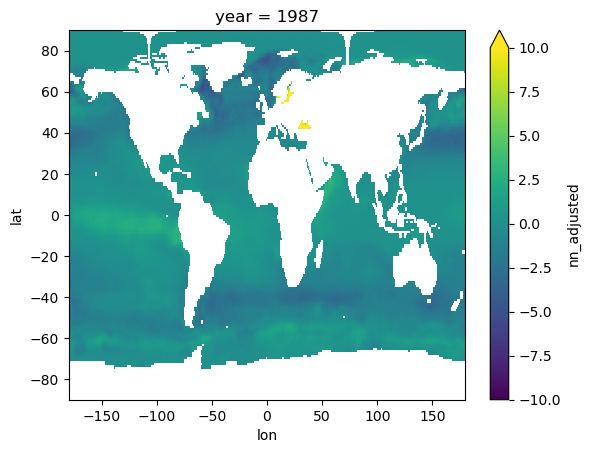

In [61]:
dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/fgco2_ems/SOM-FFN/results/Autoencoder/run_set_4/N35_v33_decoupled_LNone_arch2_batch64_e55_LE/E1/'
nn = xr.open_mfdataset(str(Path(dir, "*.nc")), combine='nested', concat_dim='year').load()
nn['nn_adjusted'][0,:12].mean('lead_time').plot(vmin = -10, vmax = 10)

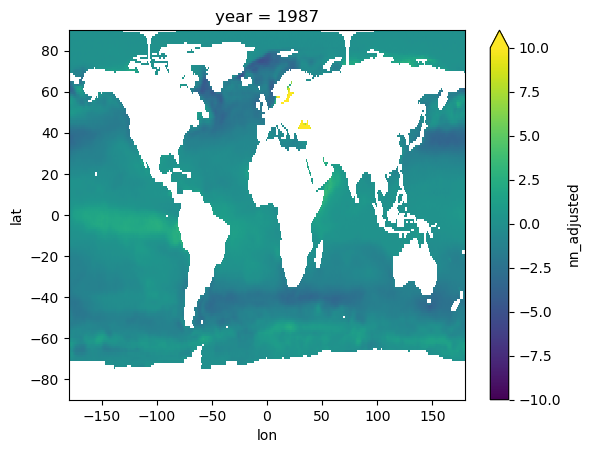

In [23]:
dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/fgco2_ems/SOM-FFN/results/Autoencoder/run_set_5/N35_v33_decoupled_LNone_arch2_batch64-64_e20-85/'
nn = xr.open_mfdataset(str(Path(dir, "*.nc")), combine='nested', concat_dim='year').load()
nn['nn_adjusted'][0,:12].mean('lead_time').plot(vmin = -10, vmax = 10)

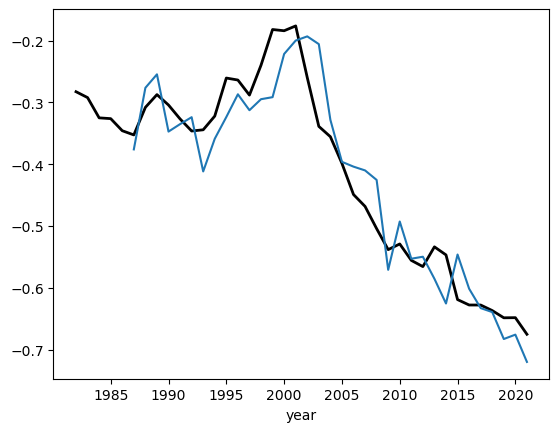

In [10]:


dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/fgco2_ems/SOM-FFN/results/Autoencoder/run_set_5/N35_v33_decoupled_LNone_arch2_batch64-64_e20-85/'
nn = xr.open_mfdataset(str(Path(dir, "*.nc")), combine='nested', concat_dim='year').load()

((obs_raw* weights).sum(['lat','lon'])/(weights).sum(['lat','lon']))[:,:12].mean('month').plot(color = 'k', linewidth = 2)
((nn['nn_adjusted']* weights).sum(['lat','lon'])/(weights).sum(['lat','lon']))[:,:12].mean('lead_time').plot()

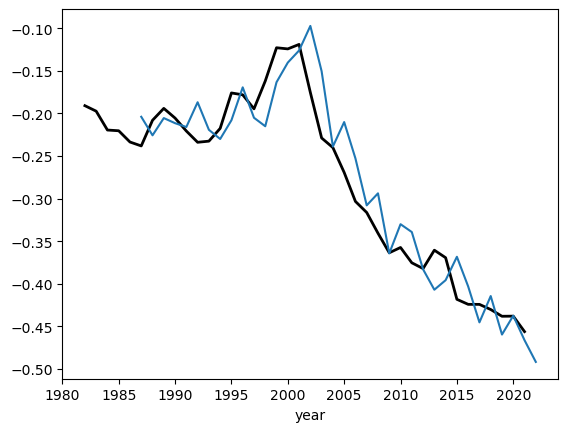

In [20]:
dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/fgco2_ems/SOM-FFN/results/Autoencoder/run_set_3/N35_v33_decoupled_LNone_arch2_batch64_e50_LE/E1/'
nn = xr.open_mfdataset(str(Path(dir, "*.nc")), combine='nested', concat_dim='year').load()

((obs_raw* weights).sum(['lat','lon'])/(weights).sum(['lat','lon']))[:,:12].mean('month').plot(color = 'k', linewidth = 2)
((nn['nn_adjusted']* weights).sum(['lat','lon'])/(weights).sum(['lat','lon']))[:,:12].mean('lead_time').plot()

### rest

In [18]:
hyperparam = params["hyperparam"]
reg_scale = params["reg_scale"]
model = params["model"]
hidden_dims = params["hidden_dims"]
time_features = params["time_features"]
epochs = params["epochs"]
batch_size = params["batch_size"]
batch_normalization = params["batch_normalization"]
dropout_rate = params["dropout_rate"]

optimizer = params["optimizer"]
lr = params["lr"]

forecast_preprocessing_steps = params["forecast_preprocessing_steps"]
observations_preprocessing_steps = params["observations_preprocessing_steps"]

loss_region = params["loss_region"]
subset_dimensions = params["subset_dimensions"]

forecast_preprocessing_steps_patterns =  [('anomalies', AnomaliesScaler_v1(axis=0)),  ('standardize', Standardizer()) ]
observations_preprocessing_steps_patterns = [ ('anomalies', AnomaliesScaler_v2(axis=0))]


forecast_preprocessing_steps_mean = [
('anomalies', AnomaliesScaler_v1(axis=0)), 
('standardize', Standardizer()) ]

observations_preprocessing_steps_mean = [
('anomalies', AnomaliesScaler_v2(axis=0))  ]

In [10]:
test_years = ds_raw_ensemble_mean.year[-n_years:].to_numpy()

In [11]:
test_year = 2019
train_years = ds_raw_ensemble_mean.year[ds_raw_ensemble_mean.year < test_year].to_numpy()
n_train = len(train_years)
train_mask = create_train_mask(ds_raw_ensemble_mean[:n_train,...])

In [12]:
ds_baseline_mean = ds_raw_ensemble_mean[:n_train,...]
obs_baseline_mean = obs_raw[:n_train,...]

ds_baseline_patterns = ds_raw_ensemble_mean_patterns[:n_train,...]
obs_baseline_patterns = obs_raw_patterns[:n_train,...]


In [19]:
if 'ensembles' in ds_raw_ensemble_mean.dims: ## PG: Broadcast the mask to the correct shape if you have an ensembles dim.
    preprocessing_mask_fct = np.broadcast_to(train_mask[...,None,None,None,None], ds_baseline_patterns.shape)
else:
    preprocessing_mask_fct = np.broadcast_to(train_mask[...,None,None,None], ds_baseline_patterns.shape)


preprocessing_mask_obs_mean = np.broadcast_to(train_mask[...,None,None], obs_baseline_mean.shape)
preprocessing_mask_obs_patterns = np.broadcast_to(train_mask[...,None,None,None], obs_baseline_patterns.shape)





In [20]:
ds_pipeline_mean = PreprocessingPipeline(forecast_preprocessing_steps_mean).fit(ds_baseline_mean, mask=preprocessing_mask_fct)
ds_mean  = ds_pipeline_mean.transform(ds_raw_ensemble_mean)

obs_pipeline_mean  = PreprocessingPipeline(observations_preprocessing_steps_mean ).fit(obs_baseline_mean , mask=preprocessing_mask_obs_mean)
# if 'standardize' in ds_pipeline_mean.steps:
#     obs_pipeline_mean .add_fitted_preprocessor(ds_pipeline_mean.get_preprocessors('standardize'), 'standardize')
obs_mean  = obs_pipeline_mean.transform(obs_raw)



In [21]:
ds_pipeline_patterns = PreprocessingPipeline(forecast_preprocessing_steps_patterns).fit(ds_baseline_patterns, mask=preprocessing_mask_fct)
ds_patterns = ds_pipeline_patterns.transform(ds_raw_ensemble_mean_patterns)

obs_pipeline_patterns = PreprocessingPipeline(observations_preprocessing_steps_patterns).fit(obs_baseline_patterns, mask=preprocessing_mask_obs_patterns)
if 'standardize' in ds_pipeline_patterns.steps:
    obs_pipeline_patterns.add_fitted_preprocessor(ds_pipeline_patterns.get_preprocessors('standardize'), 'standardize')
obs_patterns = obs_pipeline_patterns.transform(obs_raw_patterns)

year_max = ds_patterns[:n_train].year[-1].values 

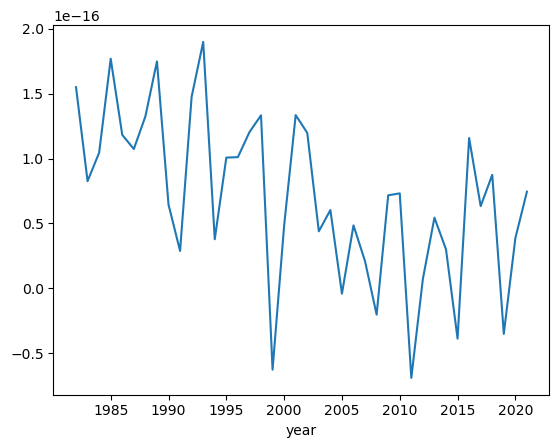

In [22]:
(((ds_patterns) * weights).sum(['lat','lon'])/ weights.sum(['lat','lon']))[:,:12].mean('lead_time').plot()

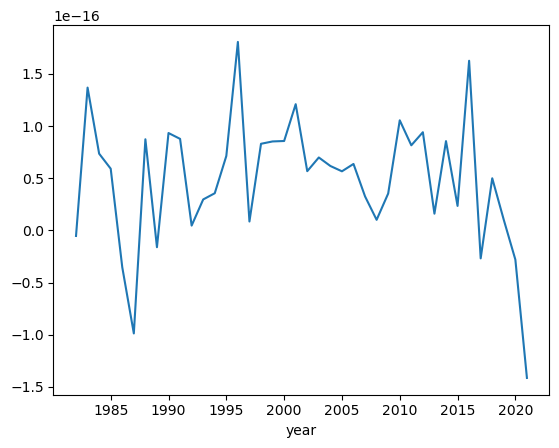

In [23]:
(((obs_patterns) * weights).sum(['lat','lon'])/ weights.sum(['lat','lon']))[:,:12].mean('month').plot()
# ds_patterns[0,0].plot()

In [16]:
lead_time = None
ds_train = ds[:n_train,...]
obs_train = obs[:n_train,...]
ds_test = ds[n_train:n_train + 1,...]
obs_test = obs[n_train:n_train + 1,...]

In [17]:
weights = np.cos(np.ones_like(ds_train.lon) * np.flip(np.deg2rad(ds_train.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = ds_train.dims[-2:], name = 'weights').assign_coords({'lat': ds_train.lat, 'lon' : ds_train.lon}) # Create an DataArray to pass to Spatialnanremove() 

Text(0.5, 1.0, 'V3')

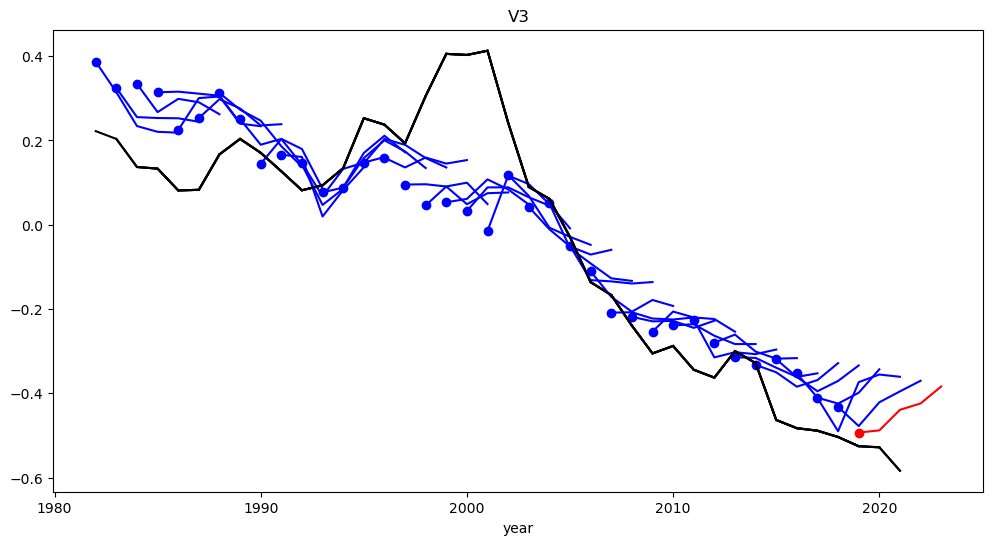

In [17]:
plt.figure(figsize = (12,6))
for y in ds_train.year:
    ds = xr.concat([ds_train.sel(year = y)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'b')
    plt.scatter(y, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'b')

    ds = xr.concat([obs_train.sel(year = y)[12*i:12*(i+1)].mean('month') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ds = ds.where(~np.isnan(ds), drop = True)
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'k')

ds = xr.concat([ds_test.sel(year = y + 1)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + 1 + np.arange(0,lead_years))

((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'r')
plt.scatter(y+1, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'r')
plt.title('V3')

Text(0.5, 1.0, 'V3 spatial std ')

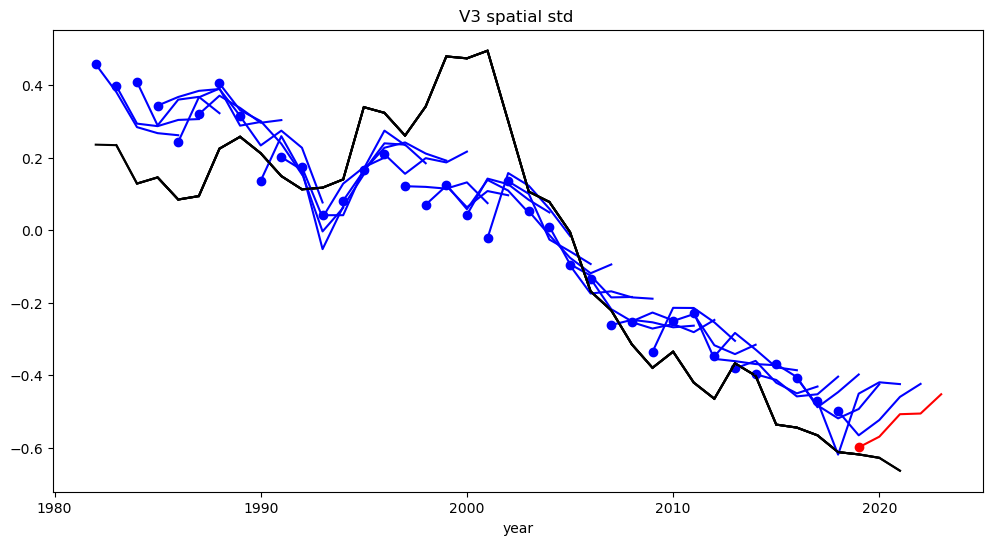

In [18]:
plt.figure(figsize = (12,6))
for y in ds_train.year:
    ds = xr.concat([ds_train.sel(year = y)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'b')
    plt.scatter(y, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'b')

    ds = xr.concat([obs_train.sel(year = y)[12*i:12*(i+1)].mean('month') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ds = ds.where(~np.isnan(ds), drop = True)
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'k')

ds = xr.concat([ds_test.sel(year = y + 1)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + 1 + np.arange(0,lead_years))

((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'r')
plt.scatter(y+1, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'r')
plt.title('V3 spatial std ')

Text(0.5, 1.0, 'Vdet spatial std ')

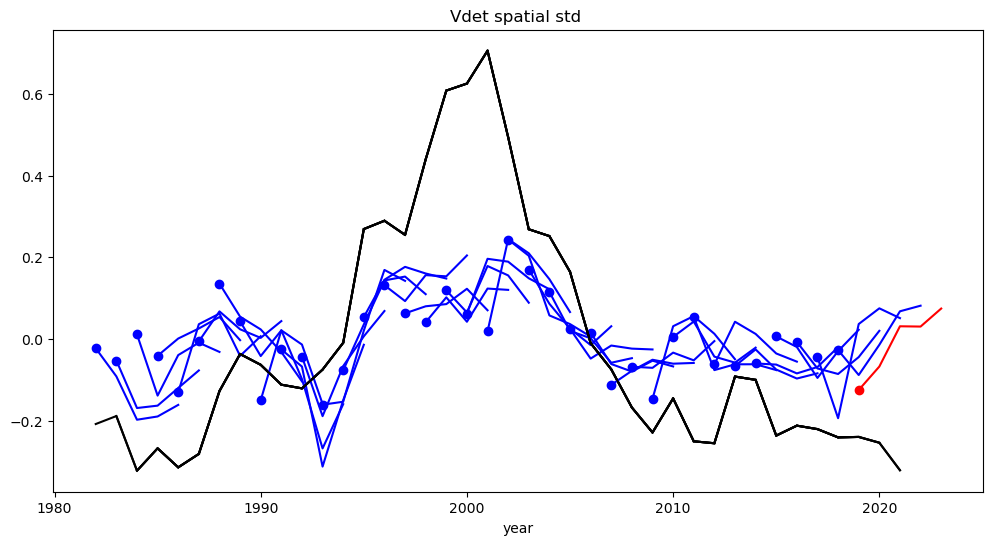

In [26]:
plt.figure(figsize = (12,6))
for y in ds_train.year:
    ds = xr.concat([ds_train.sel(year = y)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'b')
    plt.scatter(y, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'b')

    ds = xr.concat([obs_train.sel(year = y)[12*i:12*(i+1)].mean('month') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ds = ds.where(~np.isnan(ds), drop = True)
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'k')

ds = xr.concat([ds_test.sel(year = y + 1)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + 1 + np.arange(0,lead_years))

((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'r')
plt.scatter(y+1, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'r')
plt.title('Vdet spatial std ')

Text(0.5, 1.0, 'V2')

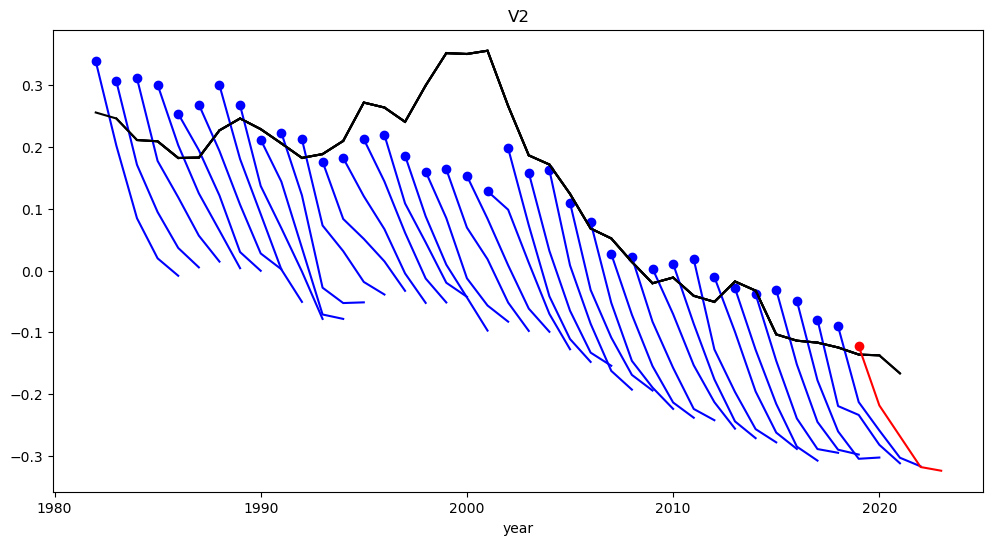

: 

In [17]:
plt.figure(figsize = (12,6))
for y in ds_train.year:
    ds = xr.concat([ds_train.sel(year = y)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'b')
    plt.scatter(y, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'b')

    ds = xr.concat([obs_train.sel(year = y)[12*i:12*(i+1)].mean('month') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ds = ds.where(~np.isnan(ds), drop = True)
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'k')

ds = xr.concat([ds_test.sel(year = y + 1)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + 1 + np.arange(0,lead_years))

((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'r')
plt.scatter(y+1, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'r')
plt.title('V2')

In [ ]:
plt.figure(figsize = (12,6))
for y in ds_train.year:
    ds = xr.concat([ds_train.sel(year = y)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'b')
    plt.scatter(y, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'b')

    ds = xr.concat([obs_train.sel(year = y)[12*i:12*(i+1)].mean('month') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + np.arange(0,lead_years))
    ds = ds.where(~np.isnan(ds), drop = True)
    ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'k')

ds = xr.concat([ds_test.sel(year = y + 1)[12*i:12*(i+1)].mean('lead_time') for i in range(lead_years)], dim = 'year').assign_coords(year = y.data + 1 + np.arange(0,lead_years))

((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).plot(color = 'r')
plt.scatter(y+1, ((ds * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])).isel(year = 0),color = 'r')
plt.title('V global anomlaies spatial std')

In [19]:

weights_ = weights.copy()
nanremover = Spatialnanremove() ## PG: Get an instance of the class
nanremover.fit(ds_train[:,:12,...], obs_train[:,:12,...]) 
ds_train = nanremover.sample(ds_train) ## PG: flatten and sample training data at those locations
obs_train = nanremover.sample(obs_train) ## PG: flatten and sample obs data at those locations
weights = nanremover.sample(weights) ## PG: flatten and sample weighs at those locations
weights_ = nanremover.sample(weights_)

/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [34]:
train_set = XArrayDataset(ds_test, obs_test, in_memory=True, lead_time=None, time_features=['month_sin', 'month_cos'],ensemble_features =None, aligned = True, year_max = 2019, extra_predictors = atm_co2) 


In [47]:
dataloader = DataLoader(train_set, batch_size=8, shuffle=True)


263

In [49]:
(x,y) = next(iter(dataloader))   

In [72]:
y_1 = (y * weights).sum(dim = -1)/ weights.sum(dim = -1)
y_0 = y - y_1.unsqueeze(-1).expand_as(y)

In [80]:
np.ones([batch_size]).shape

(16,)

In [77]:
weights.shape

torch.Size([40096])

In [ ]:
y_0 = y - ((y * weights).sum(dim = -1)/ weights.sum(dim = -1))
y_1 = (y * weights).sum(dim = -1)/ weights.sum(dim = -1)
y = (y_0.to(device), y_1.to(device))